## xDeepFM : the eXtreme Deep Factorization Machine

This notebook will give you an overview of Snack Recommendation system & how to train an xDeepFM model. xDeepFM [1] is a deep learning-based model aims at capturing both lower- and higher-order feature interactions for precise recommender systems. Thus it can learn feature interactions more effectively and manual feature engineering effort can be substantially reduced. To summarize, xDeepFM has the following key properties:

- It contains a component, named CIN, that learns feature interactions in an explicit fashion and in vector-wise level;
- It contains a traditional DNN component that learns feature interactions in an implicit fashion and in bit-wise level.
- The implementation makes this model quite configurable. We can enable different subsets of components by setting hyperparameters like use_Linear_part, use_FM_part, use_CIN_part, and use_DNN_part. For example, by enabling only the use_Linear_part and use_FM_part, we can get a classical FM model.



In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import xDeepFM
from deepctr.inputs import  SparseFeat, DenseFeat,get_feature_names
import os 

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

import warnings
warnings.filterwarnings('ignore')

Number of CPU cores: 8


### 1. Data Preparation 

In [6]:
# reading criteo_sample data
os.chdir(r'N:\ALGORITHMIC MARKETING\Assignment4')

df = pd.read_csv('data/Snacks_CTR_Data.csv')
df.head(10)

,Unnamed: 0,label,I1,I2,I3,I4,I5,I6,I7,I8,...,C21,C22,C23,C24,C25,C26,Customer_Name,Customer_Id,Campaign_name,Campaign_id
0,0,0,NaN,3,260.0,NaN,17668.0,NaN,NaN,33.0,...,0429f84b,NaN,3a171ecb,c0d61a5c,NaN,NaN,Rachel Salas,0,Snakku,100230
1,1,0,NaN,-1,19.0,35.0,30251.0,247.0,1.0,35.0,...,5155d8a3,NaN,be7c41b4,ded4aac9,NaN,NaN,Benjamin Collins,1,Love with food,100231
2,2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,...,2e01979f,NaN,bcdee96c,6d5d1302,NaN,NaN,Rachel Salas,0,Candy Club,100232
3,3,0,NaN,13,1.0,4.0,16836.0,200.0,5.0,4.0,...,e587c466,NaN,32c7478e,3b183c5c,NaN,NaN,Rachel Salas,0,Nature Box,100233
4,4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,...,0e8585d2,NaN,32c7478e,0d4a6d1a,001f3601,92c878de,Rachel Salas,0,Nature Box,100233
5,5,0,0.0,-1,63.0,40.0,1470.0,61.0,4.0,37.0,...,7633c7c8,NaN,32c7478e,17f458f7,001f3601,71236095,Benjamin Collins,1,Nature Box,100233
6,6,0,0.0,370,4.0,1.0,1787.0,65.0,14.0,25.0,...,5c8dc711,NaN,423fab69,45ab94c8,2bf691b1,c84c4aec,Rachel Salas,0,ZenPop,100234
7,7,1,19.0,10,30.0,10.0,1.0,3.0,33.0,47.0,...,c2a93b37,NaN,32c7478e,1793a828,e8b83407,2fede552,Rachel Salas,0,Nature Box,100233
8,8,0,0.0,0,36.0,22.0,4684.0,217.0,9.0,35.0,...,af5dc647,NaN,dbb486d7,1793a828,NaN,NaN,Nicole Smith,2,World Sampler,100235
9,9,0,2.0,11,8.0,23.0,30.0,11.0,2.0,8.0,...,31c8e642,NaN,c7dc6720,3e983c86,9b3e8820,d597922b,Rachel Salas,0,FitSnack,100236


In [7]:
data = df.copy(deep=True)

In [8]:
# categorising the features into sparse/dense feature set
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

# data imputation for missing values
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)

# creating target variable
target = ['label']

In [9]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C21,C22,C23,C24,C25,C26,Customer_Name,Customer_Id,Campaign_name,Campaign_id
0,0,0.0,3,260.0,0.0,17668.0,0.0,0.0,33.0,0.0,...,0429f84b,-1,3a171ecb,c0d61a5c,-1,-1,Rachel Salas,0,Snakku,100230
1,0,0.0,-1,19.0,35.0,30251.0,247.0,1.0,35.0,160.0,...,5155d8a3,-1,be7c41b4,ded4aac9,-1,-1,Benjamin Collins,1,Love with food,100231
2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,523.0,...,2e01979f,-1,bcdee96c,6d5d1302,-1,-1,Rachel Salas,0,Candy Club,100232
3,0,0.0,13,1.0,4.0,16836.0,200.0,5.0,4.0,29.0,...,e587c466,-1,32c7478e,3b183c5c,-1,-1,Rachel Salas,0,Nature Box,100233
4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,37.0,...,0e8585d2,-1,32c7478e,0d4a6d1a,001f3601,92c878de,Rachel Salas,0,Nature Box,100233


In [10]:
# encoding function
def encoding(data,feat,encoder):
    data[feat] = encoder.fit_transform(data[feat])
# encoding for categorical features
[encoding(data,feat,LabelEncoder()) for feat in sparse_features]
# Using normalization for dense feature
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])


In [11]:
# creating a 4 bit embedding for every sparse feature
sparse_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4) \
for i,feat in enumerate(sparse_features)]

In [12]:
# creating a dense feat
dense_feature_columns = [DenseFeat(feat, 1) for feat in dense_features]

In [13]:
# features to be used for dnn part of xdeepfm
dnn_feature_columns = sparse_feature_columns + dense_feature_columns
# features to be used for linear part of xdeepfm
linear_feature_columns = sparse_feature_columns + dense_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [15]:
dnn_feature_columns

[SparseFeat(name='C1', vocabulary_size=27, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='C2', vocabulary_size=92, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C2', group_name='default_group'),
 SparseFeat(name='C3', vocabulary_size=172, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C3', group_name='default_group'),
 SparseFeat(name='C4', vocabulary_size=157, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C4', group_name='default_group'),
 SparseFeat(name='C5', vocabulary_size=12, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C5', group_name='default_group'),
 SparseFeat(name='C6', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C6', group_name='default_group'),
 SparseFeat(name='C7', vocabulary_size=183, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C7', group_name='default_group'),
 SparseFeat

In [16]:
linear_feature_columns

[SparseFeat(name='C1', vocabulary_size=27, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='C2', vocabulary_size=92, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C2', group_name='default_group'),
 SparseFeat(name='C3', vocabulary_size=172, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C3', group_name='default_group'),
 SparseFeat(name='C4', vocabulary_size=157, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C4', group_name='default_group'),
 SparseFeat(name='C5', vocabulary_size=12, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C5', group_name='default_group'),
 SparseFeat(name='C6', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C6', group_name='default_group'),
 SparseFeat(name='C7', vocabulary_size=183, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C7', group_name='default_group'),
 SparseFeat

### Data Splitting

In [16]:
# creating train test splits
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

### Modeling and Training 

In [17]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256),\
cin_layer_size=(128, 128), \
cin_split_half=True, cin_activation='relu'\
,l2_reg_linear=1e-05,\
l2_reg_embedding=1e-05, l2_reg_dnn=0, l2_reg_cin=0, \
init_std=0.0001,seed=1024, dnn_dropout=0,dnn_activation='relu', \
dnn_use_bn=False, task='binary')

WARNING - From C:\Users\nikhi\Anaconda3\envs\reco_gpu\lib\site-packages\deepctr\layers\utils.py:167: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
C5 (InputL

In [19]:
train_model_input

{'C1': array([16,  0,  0, 11,  0,  0, 16, 21,  0, 16,  0, 16,  0,  0,  9,  0, 11,
         0,  0, 11, 10,  0, 19,  0, 11,  0,  7,  0,  0,  0,  0,  0, 11, 11,
         0,  4,  0, 10, 11, 10,  9,  0, 12, 11,  0,  0, 11, 24,  9, 16,  0,
         0,  8, 14,  0, 11, 11,  0, 16,  0, 11,  0, 22,  0, 11, 21, 21,  0,
         3, 16, 13,  0,  0,  0, 23,  6,  0,  0,  6,  0,  0,  0, 19,  0, 11,
         6, 11,  0,  0,  0, 11,  0, 21, 21,  0,  0,  0,  0,  0, 16, 11,  0,
        18, 15,  3,  2,  0,  0,  0, 11,  0,  0, 11, 26,  0, 11, 11, 11, 11,
         0, 16, 25, 11,  9,  0,  6,  6, 11,  0, 16, 16,  9, 25,  9,  1,  0,
         0,  9, 11,  0,  0, 11, 14, 21,  9, 11, 16, 11,  9, 18, 21,  7, 21,
         0, 20,  0,  0, 11,  9,  9]),
 'C2': array([82,  5, 18, 16, 50, 49, 56, 68, 28, 33, 77, 53,  0, 18, 30, 46, 46,
        18, 43, 62, 12, 30, 36, 23, 44, 18, 31, 19, 35, 89, 33, 11,  3, 23,
        30, 38, 14, 55, 17, 26, 28, 41, 13, 10, 18, 57, 18, 25, 18, 82,  6,
        46, 58, 18, 19, 15, 13, 91, 39

In [21]:
#compiling the model
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'], )
# training the model
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Train on 128 samples, validate on 32 samples
Epoch 1/10
 - 3s - loss: 0.4762 - binary_crossentropy: 0.4762 - val_loss: 0.6574 - val_binary_crossentropy: 0.6574
Epoch 2/10
 - 0s - loss: 0.4598 - binary_crossentropy: 0.4598 - val_loss: 0.6497 - val_binary_crossentropy: 0.6497
Epoch 3/10
 - 0s - loss: 0.4428 - binary_crossentropy: 0.4428 - val_loss: 0.6450 - val_binary_crossentropy: 0.6450
Epoch 4/10
 - 0s - loss: 0.4245 - binary_crossentropy: 0.4245 - val_loss: 0.6414 - val_binary_crossentropy: 0.6414
Epoch 5/10
 - 0s - loss: 0.4050 - binary_crossentropy: 0.4049 - val_loss: 0.6374 - val_binary_crossentropy: 0.6374
Epoch 6/10
 - 0s - loss: 0.3839 - binary_crossentropy: 0.3839 - val_loss: 0.6327 - val_binary_crossentropy: 0.6327
Epoch 7/10
 - 0s - loss: 0.3611 - binary_crossentropy: 0.3611 - val_loss: 0.6279 - val_binary_crossentropy: 0.6279
Epoch 8/10
 - 0s - loss: 0.3367 - binary_crossentropy: 0.3367 - val_loss: 0.6234 - val_binary_crossentropy: 0.6233
Epoch 9/10
 - 0s - loss: 0.3108 - b

In [22]:
#predicting
pred_ans_xdeep = model.predict(test_model_input, batch_size=256)
pred_ans_xdeep[:10]

array([[0.32443517],
       [0.05845374],
       [0.44794852],
       [0.24657872],
       [0.3492706 ],
       [0.16926993],
       [0.30775207],
       [0.17227411],
       [0.21817607],
       [0.17935689]], dtype=float32)

### Evaluate xDeepFM Model

In [27]:
score = model.evaluate(test_model_input, test[target].values, verbose=0)
print('Test Cross Entropy: ', score[1])
print('Test Loss', score[0])

Test Cross Entropy:  0.5420037746429444
Test Loss 0.5420437216758728


In [28]:
train_history = history
# list all data in history
print(train_history.history.keys())

dict_keys(['val_loss', 'val_binary_crossentropy', 'loss', 'binary_crossentropy'])


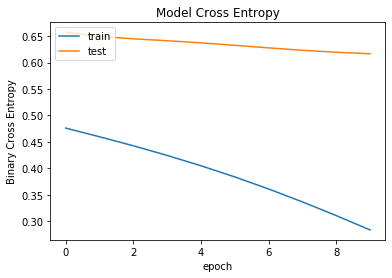

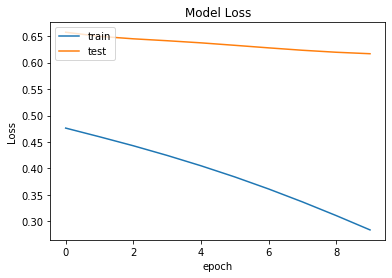

In [29]:
import matplotlib.pyplot as plt 
# summarize history for accuracy
plt.plot(train_history.history['binary_crossentropy'])
plt.plot(train_history.history['val_binary_crossentropy'])
plt.title('Model Cross Entropy')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
model.save('Snacks_xDeepFM_Model_1')

### Optimize and Tuning

In [49]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 128),\
cin_layer_size=(64, 64), \
cin_split_half=True, cin_activation='relu'\
,l2_reg_linear=1e-05,\
l2_reg_embedding=1e-05, l2_reg_dnn=1e-05, l2_reg_cin=0, \
init_std=0.0001,seed=1024, dnn_dropout=0.3,dnn_activation='relu', \
dnn_use_bn=False, task='binary')

In [50]:
#compiling the model
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'], )
# training the model
history = model.fit(train_model_input, train[target].values,
                    batch_size=128, epochs=20, verbose=2, validation_split=0.25, )

Train on 120 samples, validate on 40 samples
Epoch 1/20
 - 10s - loss: 0.6454 - binary_crossentropy: 0.6428 - val_loss: 0.6287 - val_binary_crossentropy: 0.6262
Epoch 2/20
 - 0s - loss: 0.6259 - binary_crossentropy: 0.6234 - val_loss: 0.6177 - val_binary_crossentropy: 0.6151
Epoch 3/20
 - 0s - loss: 0.6106 - binary_crossentropy: 0.6081 - val_loss: 0.6086 - val_binary_crossentropy: 0.6061
Epoch 4/20
 - 0s - loss: 0.5926 - binary_crossentropy: 0.5900 - val_loss: 0.5999 - val_binary_crossentropy: 0.5974
Epoch 5/20
 - 0s - loss: 0.5777 - binary_crossentropy: 0.5751 - val_loss: 0.5923 - val_binary_crossentropy: 0.5898
Epoch 6/20
 - 0s - loss: 0.5621 - binary_crossentropy: 0.5595 - val_loss: 0.5858 - val_binary_crossentropy: 0.5833
Epoch 7/20
 - 0s - loss: 0.5505 - binary_crossentropy: 0.5480 - val_loss: 0.5805 - val_binary_crossentropy: 0.5780
Epoch 8/20
 - 0s - loss: 0.5378 - binary_crossentropy: 0.5353 - val_loss: 0.5762 - val_binary_crossentropy: 0.5736
Epoch 9/20
 - 0s - loss: 0.5288 - 

In [51]:
score = model.evaluate(test_model_input, test[target].values, verbose=0)
print('Test Cross Entropy: ', score[1])
print('Test Loss', score[0])

Test Cross Entropy:  0.5059055805206298
Test Loss 0.5084563493728638


dict_keys(['val_loss', 'val_binary_crossentropy', 'loss', 'binary_crossentropy'])


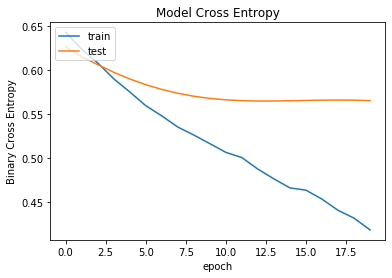

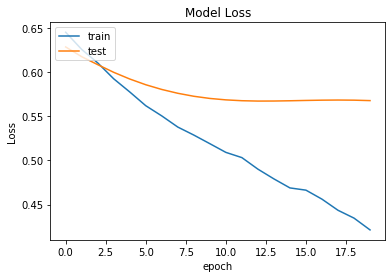

In [52]:
train_history = history
# list all data in history
print(train_history.history.keys())
import matplotlib.pyplot as plt 
# summarize history for accuracy
plt.plot(train_history.history['binary_crossentropy'])
plt.plot(train_history.history['val_binary_crossentropy'])
plt.title('Model Cross Entropy')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
model.save('Snacks_xDeepFM_Model_Optimized')